In [20]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split


In [21]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [22]:
IMAGE_LIB = 'input4/2d_images/'
MASK_LIB = 'input4/2d_masks/'
IMG_HEIGHT, IMG_WIDTH = 512,512 
SEED=42

In [23]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.tif']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im



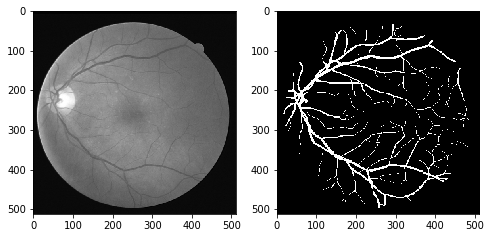

In [24]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [25]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)

In [26]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [27]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [28]:
# model.summary()

In [29]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

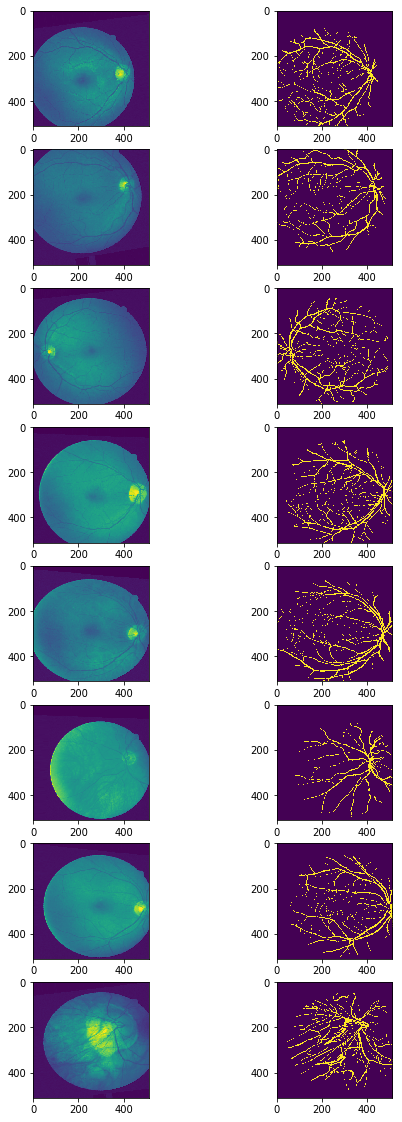

In [31]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [32]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [33]:
weight_saver = ModelCheckpoint('lung.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [34]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer])

Epoch 1/10
 - 1241s - loss: 0.3180 - dice_coef: 0.1287 - val_loss: 0.2578 - val_dice_coef: 0.1131
Epoch 2/10
 - 1337s - loss: 0.2085 - dice_coef: 0.2544 - val_loss: 0.1740 - val_dice_coef: 0.3601
Epoch 3/10
 - 1339s - loss: 0.1689 - dice_coef: 0.3958 - val_loss: 0.1560 - val_dice_coef: 0.4433
Epoch 4/10
 - 1234s - loss: 0.1540 - dice_coef: 0.4620 - val_loss: 0.1430 - val_dice_coef: 0.5003
Epoch 5/10
 - 1202s - loss: 0.1395 - dice_coef: 0.5095 - val_loss: 0.1352 - val_dice_coef: 0.5374
Epoch 6/10
 - 1188s - loss: 0.1342 - dice_coef: 0.5386 - val_loss: 0.1314 - val_dice_coef: 0.5653
Epoch 7/10
 - 1188s - loss: 0.1293 - dice_coef: 0.5525 - val_loss: 0.1328 - val_dice_coef: 0.5716
Epoch 8/10
 - 1249s - loss: 0.1282 - dice_coef: 0.5588 - val_loss: 0.1277 - val_dice_coef: 0.5741
Epoch 9/10
 - 1327s - loss: 0.1267 - dice_coef: 0.5677 - val_loss: 0.1274 - val_dice_coef: 0.5800
Epoch 10/10
 - 1234s - loss: 0.1259 - dice_coef: 0.5715 - val_loss: 0.1272 - val_dice_coef: 0.5890


In [35]:
model.save('retina_segmentation_conv_model.h5')

In [ ]:
model.load_weights('lung.h5')

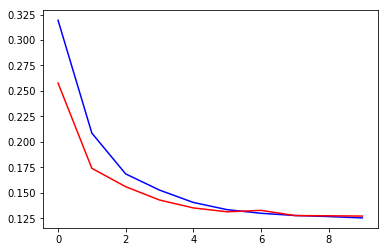

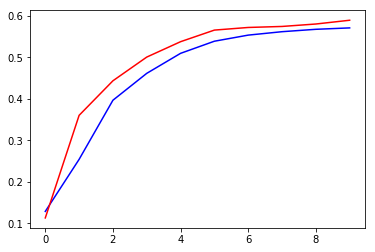

In [36]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

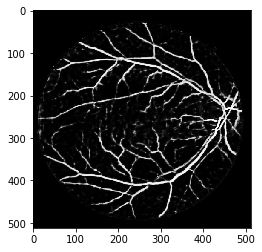

In [61]:
plt.imshow(model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

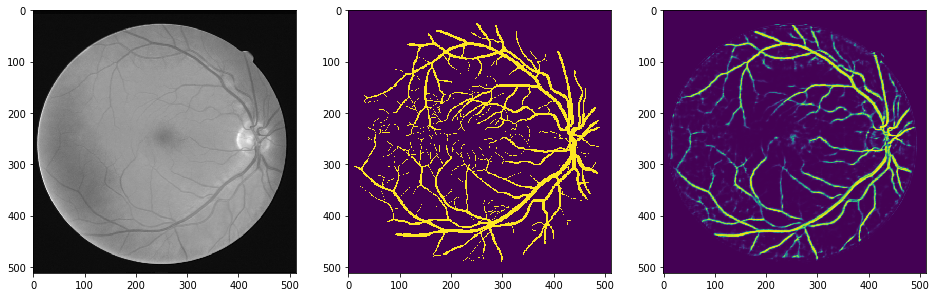

In [84]:
picture_index = 9 

y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(16,10))
ax[0].imshow(x_val[picture_index,:,:,0], cmap='gray')
ax[1].imshow(y_val[picture_index,:,:,0])
ax[2].imshow(y_hat[picture_index,:,:,0])

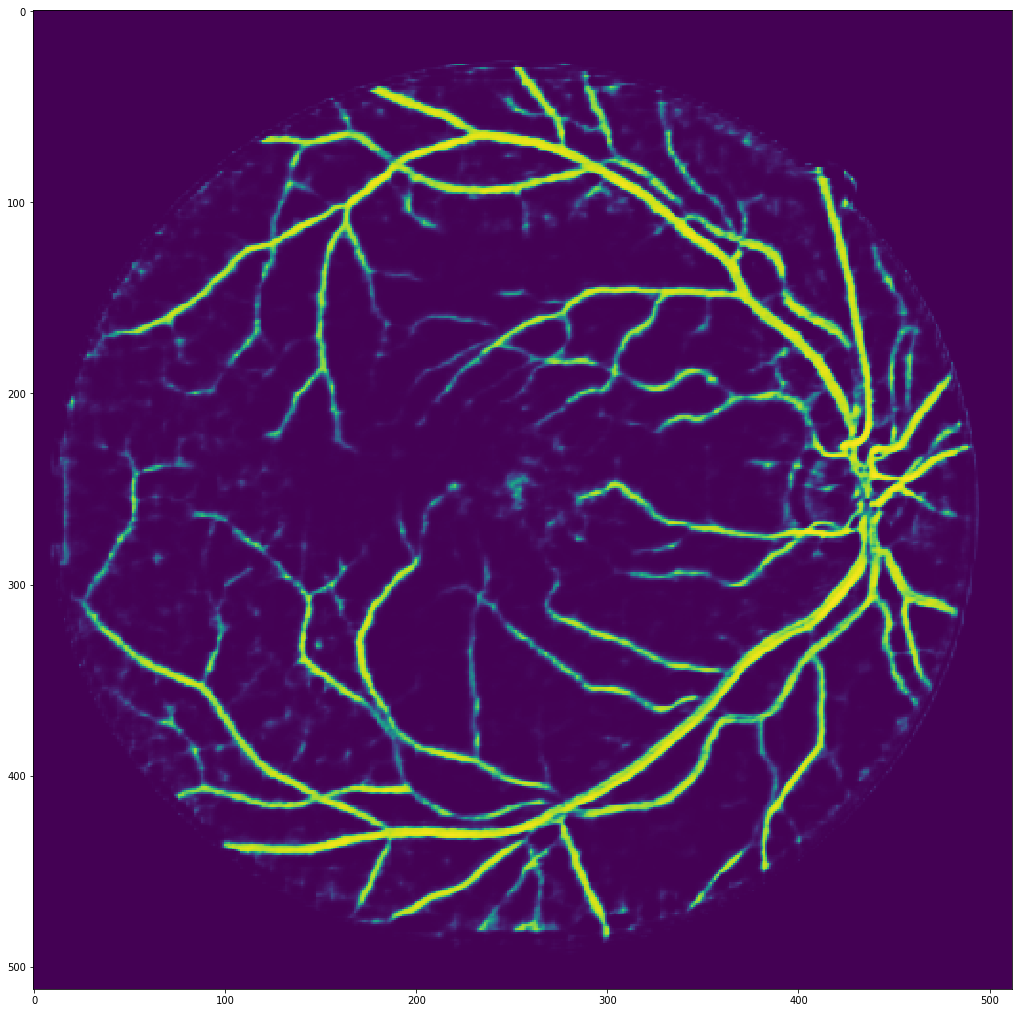

In [85]:
plt.figure(figsize=(20,18))
plt.imshow(y_hat[picture_index,:,:,0])

In [44]:
plt.imsave('CNN.png', y_hat[picture_index,:,:,0])

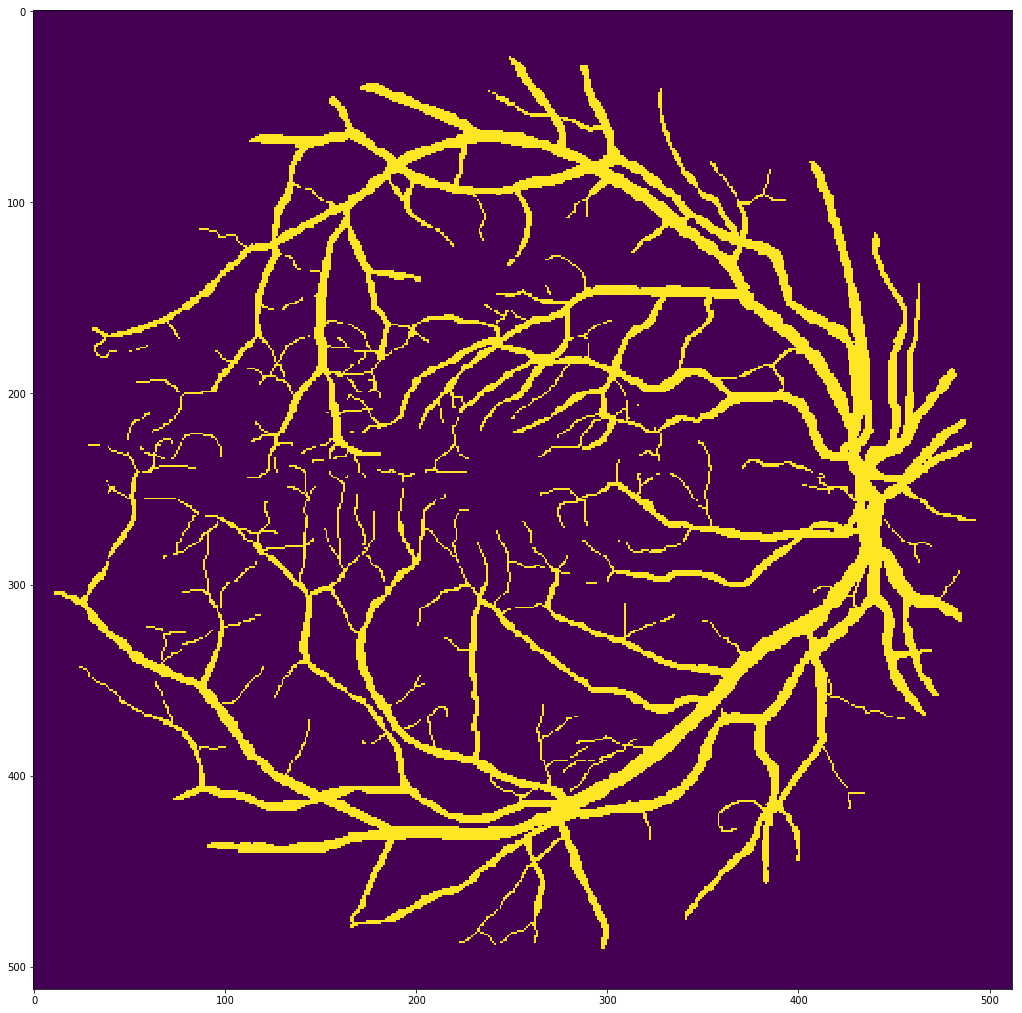

In [86]:
plt.figure(figsize=(20,18))
plt.imshow(y_val[picture_index,:,:,0])

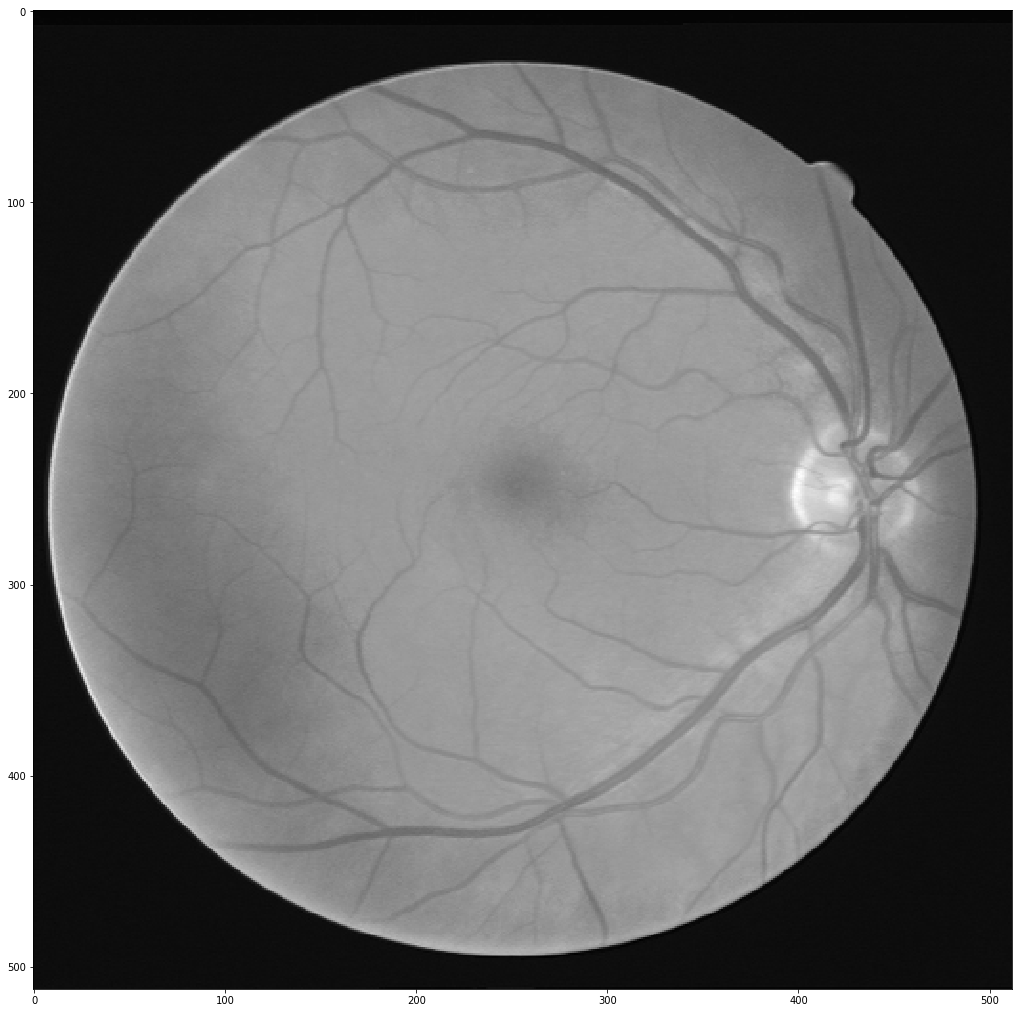

In [87]:
plt.figure(figsize=(20,18))
plt.imshow(x_val[picture_index,:,:,0],cmap='gray')